In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import os
import random
import matplotlib.pyplot as plt
from torch.nn import MSELoss
import lpips

# Importing our models and utils
from models.x16x16_to_32x32.HVAE import HierarchicalVDVAE
from utils.utils import gaussian_kl, PerceptualLoss
from utils.datasets import CIFAR_SR

In [3]:
cuda = True
device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(device)

scale_factor = 2
image_size = 32
num_channels = 3
latent_dims = [64, 128, 256]

batch_size = 64
num_epochs = 15
save_interval = num_epochs
validation_interval = 5

train_dataset = CIFAR_SR(scale_factor=2, split="train", download=True, device=device)
val_dataset = CIFAR_SR(scale_factor=2, split="test", download=True, device=device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(val_dataset)} validation samples")

cuda


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Dataset Loaded: 50000 training samples, 10000 validation samples


In [4]:
vdvae = HierarchicalVDVAE()
print(vdvae)


HierarchicalVDVAE(
  (encoder): HierarchicalEncoder(
    (in_conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (down1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (down2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu1): Linear(in_features=8192, out_features=64, bias=True)
    (fc_logvar1): Linear(in_features=8192, out_features=64, bias=True)
    (fc_mu2): Linear(in_features=16384, out_features=128, bias=True)
    (fc_logvar2): Linear(in_features=16384, out_features=128, bias=True)
    (fc_mu3): Linear(in_features=32768, out_features=256, bias=True)
    (fc_logvar3): Linear(in_features=32768, out_features=256, bias=True)
  )
  (lr_encoder): HierarchicalLREncoder(
    (in_conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (down1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=4096, out_features=64, bias=True)
    (fc2): Linear(in_features=8192, out_features=128

In [6]:
model = HierarchicalVDVAE(in_channels=3).to(device)

# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


In [8]:
num_epochs = 100
criterion2 = MSELoss()
criterion = lpips.LPIPS(net='alex').to(device)  # 'alex' is often preferred for low-res stability

beta_start = 0.0001
beta_end = 0.01

for epoch in range(num_epochs):
    model.train()
    total_loss, total_perceptual_loss, total_kl_loss = 0, 0, 0

    #beta = beta_start + (beta_end - beta_start) * (epoch / num_epochs) 
    
    for hr_imgs, lr_imgs in train_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        optimizer.zero_grad()

        recon_imgs, latents = model(hr_imgs, lr_imgs)

        kl_loss = sum([torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar))) for mu, logvar in latents])

        #perceptual_loss = criterion(recon_imgs, hr_imgs).mean()
        lpips_loss = criterion(recon_imgs, hr_imgs).mean()
        
        mse = criterion2(recon_imgs, hr_imgs)
        loss = lpips_loss + mse + kl_loss 

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_perceptual_loss += lpips_loss.item()
        total_kl_loss += kl_loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.2f} | LPIPS: {total_perceptual_loss:.2f} | KL: {total_kl_loss:.2f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\UniProgramme\anaconda3\envs\isl_segmentation\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\UniProgramme\anaconda3\envs\isl_segmentation\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\UniProgramme\anaconda3\envs\isl_segmentation\lib\site-packages\lpips\weights\v0.1\alex.pth
Epoch [1/100] | Loss: 117.19 | LPIPS: 58.15 | KL: 24.12
Epoch [2/100] | Loss: 65.99 | LPIPS: 39.97 | KL: 8.14
Epoch [3/100] | Loss: 63.51 | LPIPS: 35.39 | KL: 13.42
Epoch [4/100] | Loss: 55.55 | LPIPS: 32.00 | KL: 10.49
Epoch [5/100] | Loss: 46.72 | LPIPS: 29.43 | KL: 5.38
Epoch [6/100] | Loss: 42.04 | LPIPS: 27.78 | KL: 3.09
Epoch [7/100] | Loss: 38.63 | LPIPS: 26.47 | KL: 1.57
Epoch [8/100] | Loss: 36.49 | LPIPS: 25.11 | KL: 1.31
Epoch [9/100] | Loss: 34.28 | LPIPS: 23.87 | KL: 0.83
Epoch [10/100] | Loss: 32.58 | LPIPS: 22.74 | KL: 0.67
Epoch [11/100] | Loss: 30.86 | LPIPS: 21.65 | KL: 0.41
Epoch [12/100] | Loss: 29.62 | LPIPS: 20.74 | KL: 0.39
Epoch [13/100] | Loss: 28.43 | LPIPS: 19.92 | KL: 0.33
Epoch [14/100] | Loss: 27.25 | LPIPS: 19.10 | KL: 0.27
Epoch [15/100] | Loss: 26.11 | LPIPS: 18.33 | KL: 0.21
Epoch [16/100] | Loss: 25.04 | LPIPS: 17.57 | KL: 0.18
Epoch [17/1

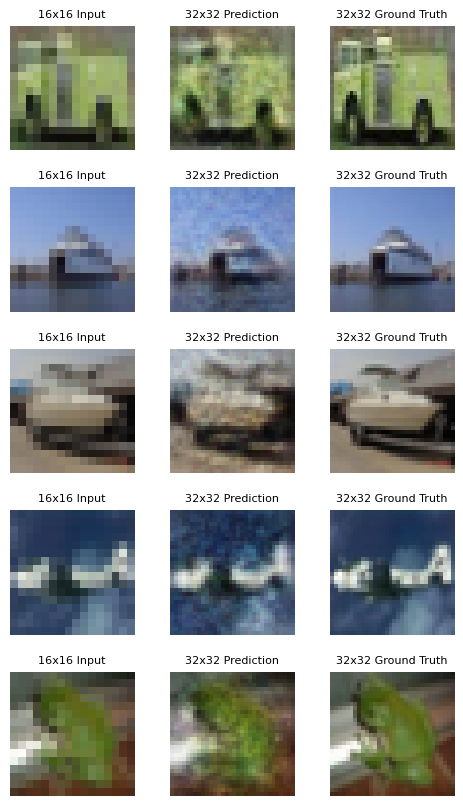

In [9]:
# Generate and Visualize Random Samples
def visualize_samples(model, num_samples=5):
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(num_samples, 3, figsize=(6, num_samples * 2)) 

        random_indices = random.sample(range(len(val_dataset)), num_samples)

        for i, idx in enumerate(random_indices):
            hr_img,lr_img = val_dataset[idx] 
            lr_img, hr_img = lr_img.unsqueeze(0).to(device), hr_img.unsqueeze(0).to(device)

            #recon_img, _ = model(hr_img,lr_img)
            recon_img = model.sample(lr_img)
            lr_img_np = lr_img.cpu().numpy().squeeze() 
            hr_img_np = hr_img.cpu().numpy().squeeze()  
            recon_img_np = recon_img.cpu().numpy().squeeze() 

 
            lr_img_np = np.transpose(lr_img_np, (1, 2, 0))  
            hr_img_np = np.transpose(hr_img_np, (1, 2, 0))  
            recon_img_np = np.transpose(recon_img_np, (1, 2, 0)) 

            axs[i, 0].imshow(lr_img_np)
            axs[i, 0].set_title("16x16 Input", fontsize=8)
            axs[i, 0].axis("off")

            axs[i, 1].imshow(recon_img_np)
            axs[i, 1].set_title("32x32 Prediction", fontsize=8)
            axs[i, 1].axis("off")

            axs[i, 2].imshow(hr_img_np)
            axs[i, 2].set_title("32x32 Ground Truth", fontsize=8)
            axs[i, 2].axis("off")

        plt.subplots_adjust(wspace=0.1, hspace=0.3)  
        plt.show()

visualize_samples(model, num_samples=5)


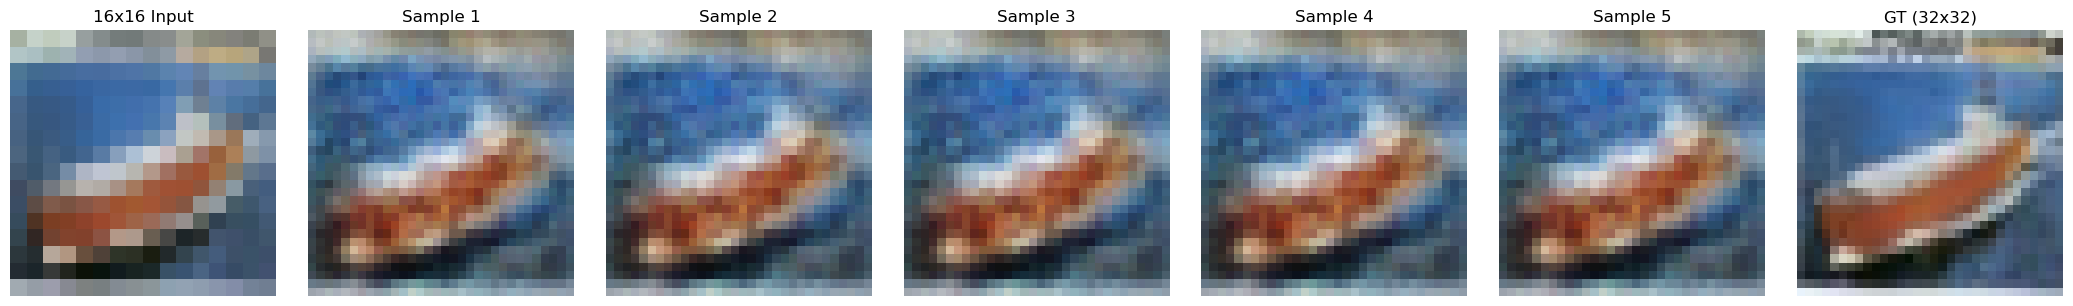

Diversity score (mean std across pixels): 0.00438
Very low diversity


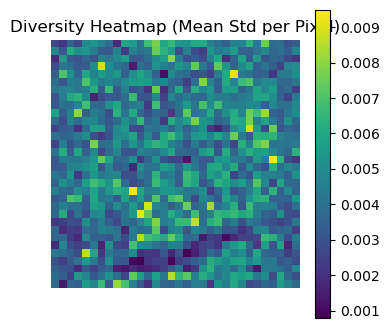

In [14]:
def visualize_diversity(model, lr_img, hr_img, num_samples=5):
    model.eval()
    generated_samples = []

    with torch.no_grad():
        fig, axs = plt.subplots(1, num_samples + 2, figsize=(3 * (num_samples + 2), 3))

        # Prepare input
        lr_img = lr_img.unsqueeze(0).to(device)

        # LR Input Image
        lr_np = lr_img.cpu().squeeze().numpy()
        lr_np = np.transpose(lr_np, (1, 2, 0))
        axs[0].imshow(lr_np)
        axs[0].set_title("16x16 Input")
        axs[0].axis("off")

        # Generate multiple predictions and store them
        for i in range(num_samples):
            recon_img = model.sample(lr_img)  # different latent each time
            recon_np = recon_img.cpu().squeeze().numpy().transpose(1, 2, 0)
            axs[i + 1].imshow(recon_np)
            axs[i + 1].set_title(f"Sample {i+1}")
            axs[i + 1].axis("off")
            generated_samples.append(recon_img.squeeze(0).cpu())  # shape = (3, H, W)


        # Show ground truth HR image
        hr_np = hr_img.cpu().numpy().transpose(1, 2, 0)
        axs[-1].imshow(hr_np)
        axs[-1].set_title("GT (32x32)")
        axs[-1].axis("off")

        plt.tight_layout()
        plt.show()

    # ----- DIVERSITY METRIC -----
    generated_stack = torch.stack(generated_samples)  # (num_samples, 3, H, W)
    std_per_pixel = torch.std(generated_stack, dim=0)  # (3, H, W)
    diversity_score = torch.mean(std_per_pixel).item()

    print(f"Diversity score (mean std across pixels): {diversity_score:.5f}")

    if diversity_score < 0.005:
        print("Very low diversity")
    elif diversity_score < 0.02:
        print("Moderate diversity")
    else:
        print("High diversity")

    # Optional: visualize diversity heatmap
    diversity_map = torch.mean(std_per_pixel, dim=0).cpu().numpy()  # (H, W)
    plt.figure(figsize=(4, 4))
    plt.imshow(diversity_map, cmap='viridis')
    plt.title("Diversity Heatmap (Mean Std per Pixel)")                                                           
    plt.colorbar()
    plt.axis("off")
    plt.show()



# Pick a random LR input
hr_img, lr_img = val_dataset[random.randint(0, len(val_dataset)-1)]
visualize_diversity(model, lr_img, hr_img, num_samples=5)



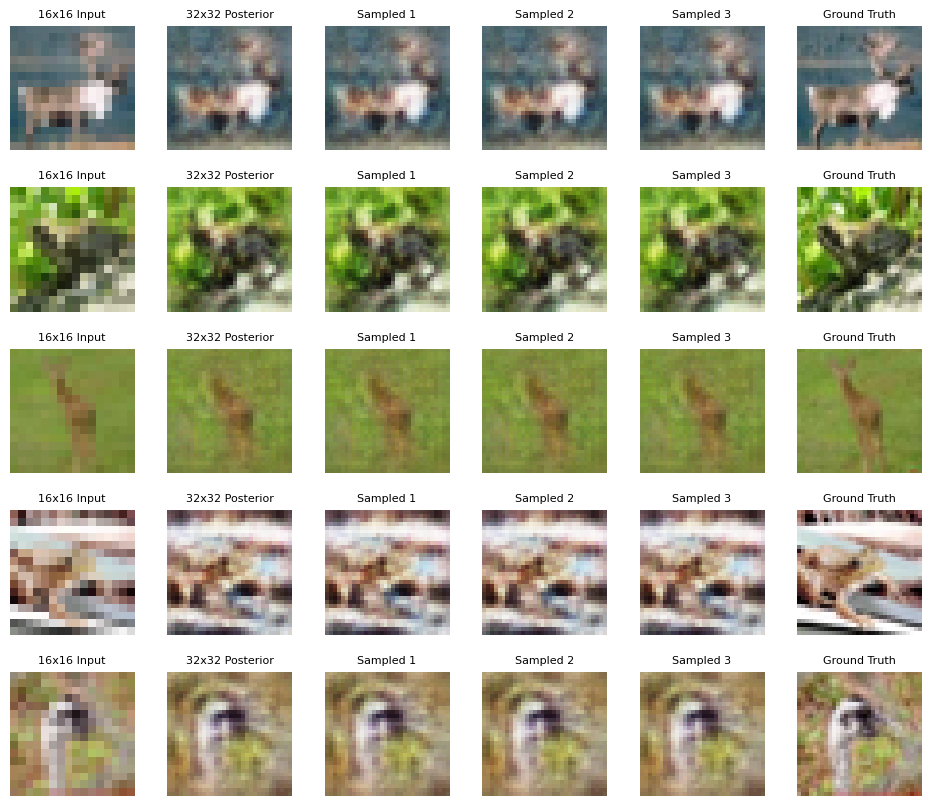

In [15]:
def visualize_samples(model, num_samples=5):
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(num_samples, 6, figsize=(12, num_samples * 2)) 

        random_indices = random.sample(range(len(val_dataset)), num_samples)

        for i, idx in enumerate(random_indices):
            hr_img, lr_img = val_dataset[idx]
            lr_img, hr_img = lr_img.unsqueeze(0).to(device), hr_img.unsqueeze(0).to(device)

            # Posterior reconstruction
            recon_posterior, _ = model(hr_img, lr_img)

            # Prior sampling
            recon_prior = model.sample(lr_img)
            recon_prior2 = model.sample2(lr_img)
            recon_prior3 = model.sample3(lr_img)

            # Convert to numpy for plotting
            lr_img_np = lr_img.cpu().squeeze().numpy().transpose(1, 2, 0)
            hr_img_np = hr_img.cpu().squeeze().numpy().transpose(1, 2, 0)
            recon_posterior_np = recon_posterior.cpu().squeeze().numpy().transpose(1, 2, 0)
            recon_prior_np = recon_prior.cpu().squeeze().numpy().transpose(1, 2, 0)
            recon_prior2_np = recon_prior2.cpu().squeeze().numpy().transpose(1, 2, 0)
            recon_prior3_np = recon_prior3.cpu().squeeze().numpy().transpose(1, 2, 0)

            axs[i, 0].imshow(lr_img_np)
            axs[i, 0].set_title("16x16 Input", fontsize=8)
            axs[i, 0].axis("off")

            axs[i, 1].imshow(recon_posterior_np)
            axs[i, 1].set_title("32x32 Posterior", fontsize=8)
            axs[i, 1].axis("off")

            axs[i, 2].imshow(recon_prior_np)
            axs[i, 2].set_title("Sampled 1", fontsize=8)
            axs[i, 2].axis("off")

            axs[i, 3].imshow(recon_prior2_np)
            axs[i, 3].set_title("Sampled 2", fontsize=8)
            axs[i, 3].axis("off")

            axs[i, 4].imshow(recon_prior3_np)
            axs[i, 4].set_title("Sampled 3", fontsize=8)
            axs[i, 4].axis("off")

            axs[i, 5].imshow(hr_img_np)
            axs[i, 5].set_title("Ground Truth", fontsize=8)
            axs[i, 5].axis("off")

        plt.subplots_adjust(wspace=0.1, hspace=0.3)  
        plt.show()

visualize_samples(model, num_samples=5)

In [16]:
path = r"E:\GNN\gnn\datasets\models_neu\cifar32x32-2xscale\100epochs\hvae_lpips.pth"
torch.save(model.state_dict(), path)


In [ ]:
#path = r"E:\GNN\gnn\datasets\vdvae.pth"
#model.load_state_dict(torch.load(path))

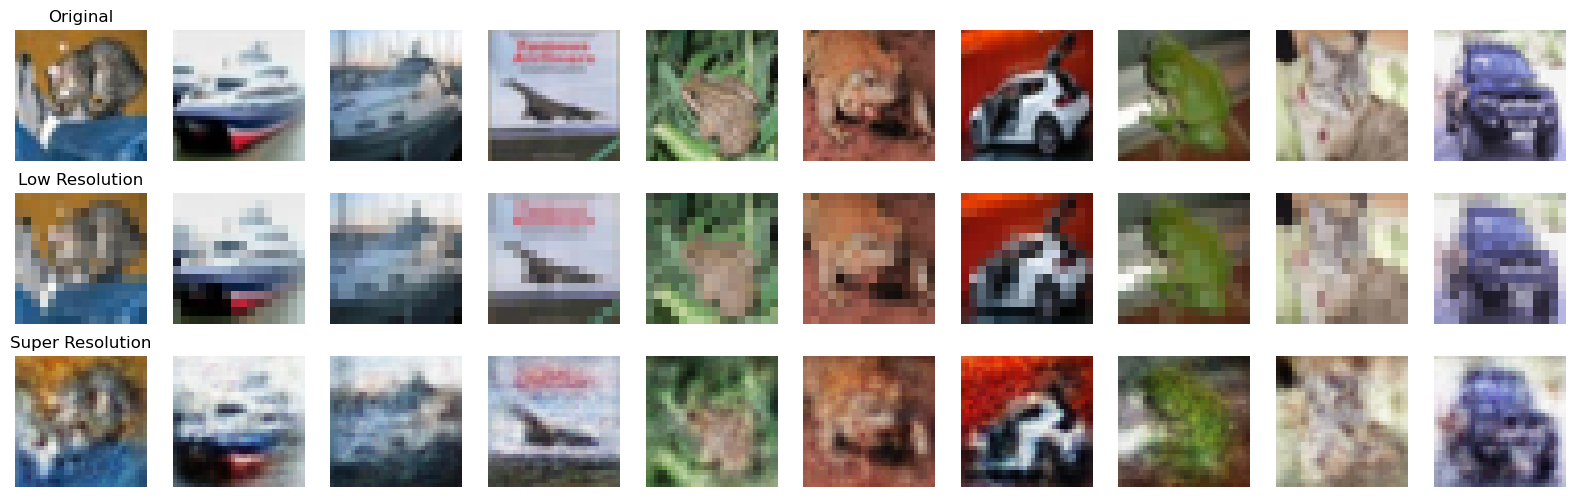

In [17]:
HR, LR = val_dataset.get_samples(1000)
SR = model.sample(LR)
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')
show_image(HR, LR, SR, 10)


In [18]:
from utils.metrics import validation_scores
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\UniProgramme\anaconda3\envs\isl_segmentation\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.005349627695977688
Perceptual: 3.457585334777832
PSNR: 23.243431091308594
SSIM: 0.7495082020759583
LPIPS: 0.30036720633506775
BRISQUE: 63.59918975830078
PSNR Consistency: 27.182485580444336
MSE Diversity: 3.0396569600910084e-05
LPIPS Diversity: 0.0027067874757449317
